# Captcha Solver using CNN and RNN Architecture

### Few of the Assumptions: 

1. The captcha length would be 5 characters.
2. The data which is added in the later stages might contain alpha characters.
3. All the future additional data will have the same dimentions and file format.
4. All the future additional data would have the same black text on the white background (orelse more pre-processing is required).  

### Corrections in the dataset:
1. Few files provided in the labelled dataset didn't have proper fileformat as the rest of them (.png).
2. Corrected few incorrectly labelled images. Example: 141931, 42422. 
These examples will not allow to perform batch training if not corrected as the architecture assumes all the images in a batch has same number of digits.

### Previous attempts:

1. Experimented with methods similar to recognizing and seperating indivual letters using Opencv and comparing the vectorial space to indentify the letters. Similar methods can be found here: https://thepythonguru.com/decoding-captchas-using-python/. 
This method of comparing the vector space seemed more time consuming than a DNN inference function. As the process requires to analyse each pixel by pixel serially. 

2. Experimented to use Opencv image pre-processing/manipulation techniques and Pytesseract to recognize the letters. http://www.robindavid.fr/opencv-tutorial/cracking-basic-captchas-with-opencv.html 
Though this method seemed simple to execute the results were not satisfactory.

### CNN + RNN + CTC Loss Implementation:

Even though the intention was to create as simple models as possible (above mentioned previous experiments) to get a good results using DNN was plauisble. Intitially started implementing simple CNN models but the results were not satisfactory as the requirements of data size for such simple CNN is huge. So I researched and found out an architecture that seemingly performs well for our usecase. 

This CNN + RNN + CTC loss architecture is quite succesful in the community for simple alphanumeric captcha recognition. This architectere implementation is taken directly from keras documentation blogs. 

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
#unzip the dataset
!unzip /content/electoral-tagged1.zip

Uploading all the image files of our training data and labelling them with theirs file names (omiting the '.png')

In [45]:

# Path to the data directory
data_dir = Path("/content/electoral-tagged")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))

batch_size = 16
img_width = 130
img_height = 42
downsample_factor = 4

max_length = max([len(label) for label in labels])


Number of images found:  938
Number of labels found:  938


## Preprocessing

In [36]:

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}


## Create Dataset objects

In [37]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

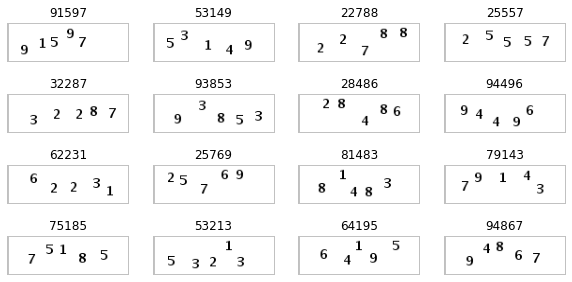

In [38]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Model

In [39]:

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 130, 42, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 130, 42, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 65, 21, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 65, 21, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

## Training

In [40]:

epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/100
53/53 [==============================] - 22s 282ms/step - loss: 14.9928 - val_loss: 12.6863
Epoch 2/100
53/53 [==============================] - 13s 244ms/step - loss: 12.6928 - val_loss: 12.6605
Epoch 3/100
53/53 [==============================] - 13s 246ms/step - loss: 12.6778 - val_loss: 12.6502
Epoch 4/100
53/53 [==============================] - 13s 244ms/step - loss: 12.6711 - val_loss: 12.6582
Epoch 5/100
53/53 [==============================] - 13s 244ms/step - loss: 12.6568 - val_loss: 12.6703
Epoch 6/100
53/53 [==============================] - 13s 247ms/step - loss: 12.6487 - val_loss: 12.6160
Epoch 7/100
53/53 [==============================] - 13s 245ms/step - loss: 12.6364 - val_loss: 12.6066
Epoch 8/100
53/53 [==============================] - 13s 243ms/step - loss: 12.6310 - val_loss: 12.5720
Epoch 9/100
53/53 [==============================] - 13s 243ms/step - loss: 12.6203 - val_loss: 12.5413
Epoch 10/100
53/53 [==============================] - 13s 245ms/

In [41]:
#Save the model
model.save('/content/model1')

INFO:tensorflow:Assets written to: /content/model1/assets


INFO:tensorflow:Assets written to: /content/model1/assets


## Inference

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 130, 42, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 130, 42, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 65, 21, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 65, 21, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 10, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 640)           0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 64)            41024 

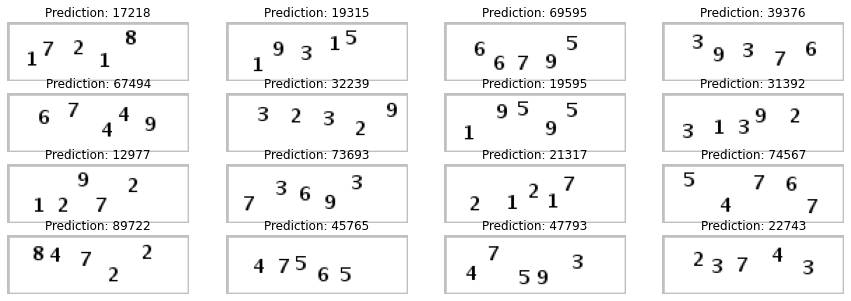

In [42]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [47]:
# Use the following snippet to load the previously trained model for further inference.
model1 = keras.models.load_model('/content/model1')